In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import utils.plot_functions as pf
import numpy as np
from cae_model import cae
import time
import utils.entropy_funcs as ef 

In [3]:
params = {}
#shitty hard coding
params["n_mem"] = 32768  #32768 #49152 for color, 32768 for grayscale

#general params
params["run_name"] = "test_run"
# params["file_location"] = "/media/tbell/datasets/natural_images.txt"
params["file_location"] = "/media/tbell/datasets/test_images.txt"
params["gpu_ids"] = ["0"]
params["output_location"] = os.path.expanduser("~")+"/CAE_Project/CAEs/model_outputs/"+params["run_name"]
params["num_threads"] = 6
params["num_epochs"] = 40
params["epoch_size"] = 49000
params["eval_interval"] = 100
params["seed"] = 1234567890

#checkpoint params
params["run_from_check"] = False
params["check_load_run_name"] = "train"
params["check_load_path"] = "/home/dpaiton/CAE_Project/CAEs/model_outputs/"+params["check_load_run_name"]+"/checkpoints/chkpt_-22800"

#image params
params["shuffle_inputs"] = True
params["batch_size"] = 100
params["img_shape_y"] = 256
params["num_colors"] = 1
params["downsample_images"] = True
params["downsample_method"] = "resize" # can be "crop" or "resize"

#learning rates
params["init_learning_rate"] = 5.0e-4
params["decay_steps"] = 10000#epoch_size*0.5*num_epochs #0.5*epoch_size
params["staircase"] = True
params["decay_rate"] = 0.9

#layer params
params["memristorify"] = False
params["god_damn_network"] = True
params["relu"] = False

#layer dimensions
params["input_channels"] = [params["num_colors"], 128, 128]
params["output_channels"] = [128, 128, 128]
params["patch_size_y"] = [9, 5, 5]
params["strides"] = [4, 2, 2]

#memristor params
params["GAMMA"] = 1.0  # slope of the out of bounds cost
params["mem_v_min"] = -1.0
params["mem_v_max"] = 1.0
params["gauss_chan"] = False

#entropy params
params["LAMBDA"] = 0.1
params["num_triangles"] = 20
params["mle_lr"] = 0.01
params["num_mle_steps"] = 10
params["quant_noise_scale"] = 1.0/128.0 # simulating quantizing u in {-1.0, 1.0} to uint8 (256 values)
mle_triangle_centers = np.linspace(params["mem_v_min"], params["mem_v_max"], params["num_triangles"])

cae_model = cae(params)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False # for debugging - log devices used by each variable

with tf.Session(config=config, graph=cae_model.graph) as sess:
  sess.run(cae_model.init_op)
  if cae_model.params["run_from_check"] == True:
    cae_model.full_saver.restore(sess, cae_model.params["check_load_path"])
  # Coordinator manages threads, checks for stopping requests
  coord = tf.train.Coordinator()
  # queue_runners are created by helper functions tf.train.string_input_producer() and tf.train.batch_join()
  enqueue_threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

  mem_std_eps = np.random.standard_normal((cae_model.params["effective_batch_size"], cae_model.params["n_mem"])).astype(np.float32)
  feed_dict={cae_model.memristor_std_eps:mem_std_eps, cae_model.triangle_centers:mle_triangle_centers}
  if not params["memristorify"] and not params["gauss_chan"]:
    quant_noise = np.random.uniform(-params["quant_noise_scale"], params["quant_noise_scale"],
      size=(cae_model.params["effective_batch_size"], cae_model.params["n_mem"]))
    feed_dict[cae_model.quantization_noise] = quant_noise

  t0 = time.time()
  # Update MLE estimate
  for mle_step in range(params["num_mle_steps"]):
    sess.run(cae_model.mle_update, feed_dict=feed_dict)
  
  #_, step, u_list = sess.run([cae_model.train_op, cae_model.global_step, cae_model.u_list])
  #u_vals = u_list[int(params["num_layers"]/2)]
  latent_ent_list, u_list = sess.run([cae_model.latent_entropies, cae_model.u_list], feed_dict)

  tri_linspace = tf.stack([tf.linspace(tf.reduce_min(cae_model.u_list[int(params["num_layers"]/2)]),
    tf.reduce_max(cae_model.u_list[int(params["num_layers"]/2)]), num=1000),]*params["n_mem"], axis=1)
  tri_evals, tri_lin_eval = sess.run([ef.eval_triangle(tri_linspace, ef.weights(cae_model.mle_thetas), cae_model.triangle_centers),
    tri_linspace], feed_dict)

  t1 = time.time()
  t_tot = t1-t0
  print("total_time: ",t_tot)
  
  coord.request_stop()
  coord.join(enqueue_threads)

total_time:  42.20658230781555


In [4]:
def calc_hist(u_val, num_bins):
    value_range = (np.min(u_val), np.max(u_val))
    hist, bin_edges = np.histogram(u_val, range=value_range, bins=num_bins)
    hist = hist/np.sum(hist)
    return bin_edges, hist

In [5]:
def plot_hists(latent_vals, u_val, num_plots, tri_x, tri_eval):
    fig, ax = plt.subplots(num_plots, 2, figsize=(20, 5*num_plots))
    #if num_plots == 1:
    #    ax = [ax]
    for plot in range(num_plots):
        entropy = latent_vals[plot]
        bin_edges, hist = calc_hist(u_val[plot], 20)
        print ("gauss_ent", plot, " ", 0.5*np.log(2*np.pi*np.e*np.var(u_val[plot])))
        print("u_var", plot, " ", np.var(u_val[plot]))
        ax[plot, 0].scatter(bin_edges[:-1], hist)
        for index in np.arange(len(hist[:-1])):
          x_points = [bin_edges[index], bin_edges[index+1]]
          y_points = [hist[index], hist[index+1]]
          ax[plot, 0].plot(x_points, y_points, linewidth=2, color="k")
        ax[plot, 0].set_title("Entropy="+str(round(entropy,4)), fontsize=18)
        ylim = ax[plot, 0].get_ylim()
        ax[plot, 0].set_ylim((0, ylim[1]))
        ax[plot, 1].bar(tri_x[plot], np.sum(tri_eval[plot], axis=1), width=1)
    plt.show()

gauss_ent 0   1.80253967846
u_var 0   2.15373
gauss_ent 1   2.2372196234
u_var 1   5.13748
gauss_ent 2   2.24301279229
u_var 2   5.19735
gauss_ent 3   1.54517489478
u_var 3   1.2872
gauss_ent 4   2.04485471448
u_var 4   3.49674
gauss_ent 5   2.04902328312
u_var 5   3.52602
gauss_ent 6   2.50572174608
u_var 6   8.78958
gauss_ent 7   1.98832941176
u_var 7   3.12296
gauss_ent 8   2.18839993644
u_var 8   4.65957
gauss_ent 9   1.75497952433
u_var 9   1.95831


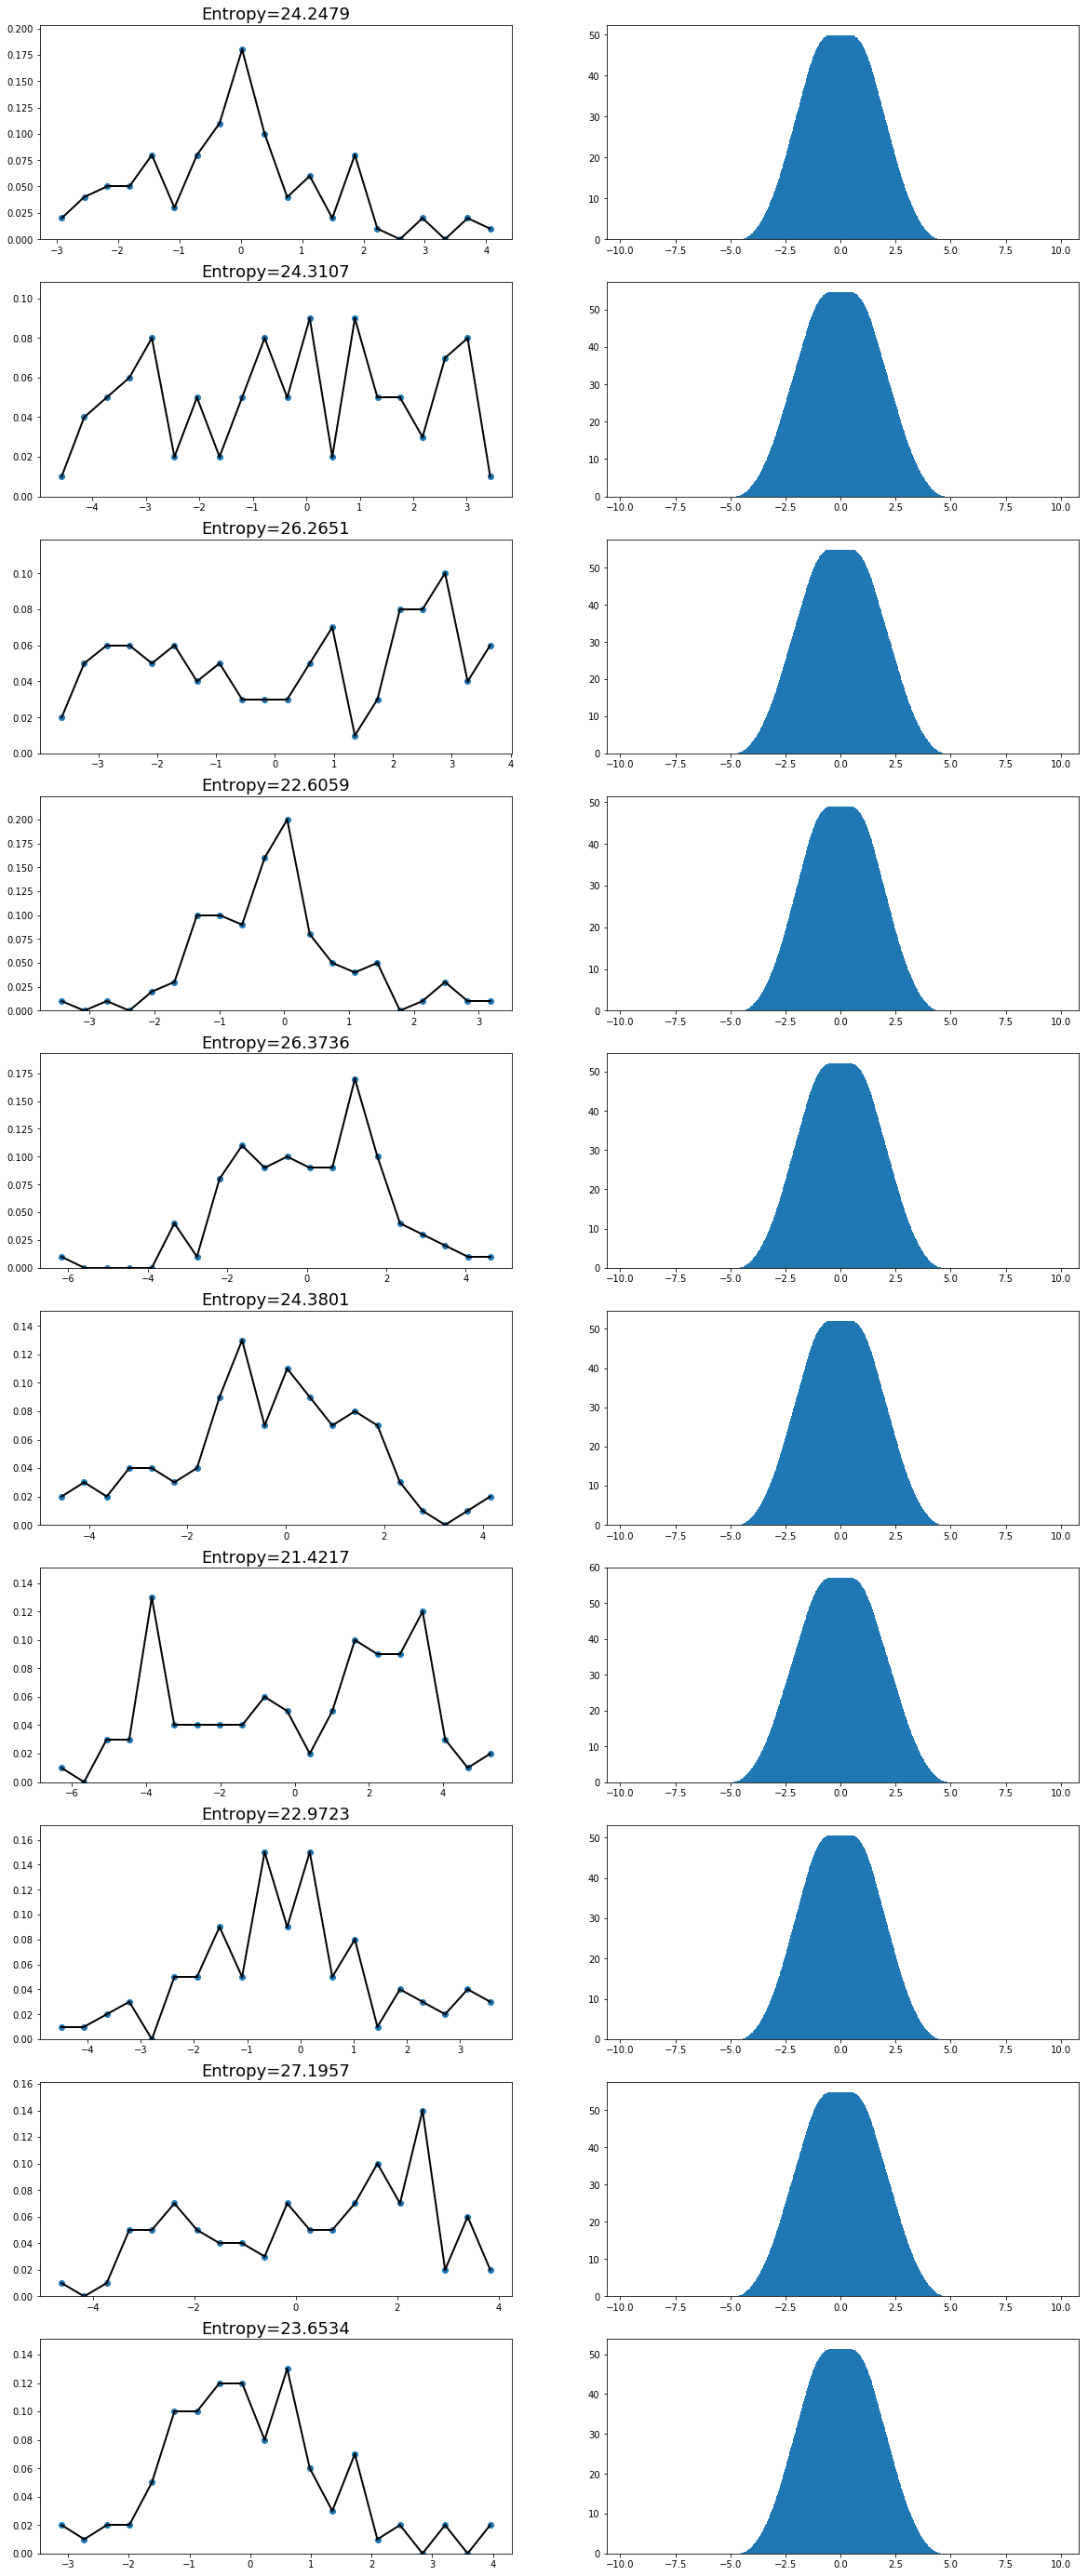

In [6]:
num_plots = 10
rand_val_index = np.random.choice(len(latent_ent_list), num_plots, replace=False)
latent_vals = [latent_ent_list[idx] for idx in rand_val_index]
u_vals = np.reshape(u_list[int(params["num_layers"]/2)], newshape=(params["batch_size"], params["n_mem"]))
u_val = [u_vals[:,idx] for idx in rand_val_index]
tri_eval = [tri_evals[:, idx, :] for idx in rand_val_index]
tri_x = [tri_lin_eval[:, idx] for idx in rand_val_index]
plot_hists(latent_vals, u_val, num_plots, tri_x, tri_eval)

In [ ]:
x = np.array([10,100,1000])
y = np.array([9.5,10,28])